In [1]:
# Import standard libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import sklearn modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Import TensorFlow modules
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# Import custom utilities
from utilities import highlight_vif, calc_vif, calc_correlation, encode_categorical_data

## Part 1: Data Preprocessing
___

#### Inspect Attrition Data Set

In [2]:
#  Import and read the attrition data
attrition_df = pd.read_csv('https://static.bc-edx.com/ai/ail-v-1-0/m19/lms/datasets/attrition.csv')

print("Shape:", attrition_df.shape)
attrition_df.head()

Shape: (1470, 27)


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,2,94,3,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,3,61,2,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,92,2,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,4,56,3,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,Research & Development,2,1,Medical,1,40,3,...,3,4,1,6,3,3,2,2,2,2


In [3]:
# Determine the number of unique values in each column.
attrition_df.nunique()

Age                         43
Attrition                    2
BusinessTravel               3
Department                   3
DistanceFromHome            29
Education                    5
EducationField               6
EnvironmentSatisfaction      4
HourlyRate                  71
JobInvolvement               4
JobLevel                     5
JobRole                      9
JobSatisfaction              4
MaritalStatus                3
NumCompaniesWorked          10
OverTime                     2
PercentSalaryHike           15
PerformanceRating            2
RelationshipSatisfaction     4
StockOptionLevel             4
TotalWorkingYears           40
TrainingTimesLastYear        7
WorkLifeBalance              4
YearsAtCompany              37
YearsInCurrentRole          19
YearsSinceLastPromotion     16
YearsWithCurrManager        18
dtype: int64

### Seperate `X` **features** and `y` **targets** from original DataFrame
___

#### **`y` Targets:** Create `y` targets and inspect...

In [4]:
# Create y_df with the Attrition and Department columns

# Define the target set.
targets = ['Attrition', 'Department']

# Create a new DataFrame with just the target set.
y_df = attrition_df[targets]

# Display the first five rows of y_df
print("Shape:", y_df.shape)
y_df.head()

Shape: (1470, 2)


,Attrition,Department
0,Yes,Sales
1,No,Research & Development
2,Yes,Research & Development
3,No,Research & Development
4,No,Research & Development


In [5]:
# Inspect the target columns' balance
for column in y_df.columns:
    display(y_df[column].value_counts())

Attrition
No     1233
Yes     237
Name: count, dtype: int64

Department
Research & Development    961
Sales                     446
Human Resources            63
Name: count, dtype: int64

In [6]:
# Inspect the unique values of the object columns in the `y_df` DataFrame
print("Display the unique values in `y_df` columns", end='\n\n')

for object_column in y_df.columns:
    unique_values = y_df[object_column].unique()
    print(f'{object_column}:\n', f'{unique_values}\n', '='*65)

Display the unique values in `y_df` columns

Attrition:
 ['Yes' 'No']
Department:
 ['Sales' 'Research & Development' 'Human Resources']


#### **`X` Features:** Create `X` features and inspect...

In [7]:
# Create a list of at least 10 column names to use as X data
features = [
    'Age',
    'BusinessTravel',
    'DistanceFromHome',
    'Education',
    'EducationField',
    'EnvironmentSatisfaction',
    'HourlyRate',
    'JobInvolvement',
    'JobLevel',
    'JobRole',
    'JobSatisfaction',
    'MaritalStatus',
    'NumCompaniesWorked',
    'OverTime',
    'PercentSalaryHike',
    'PerformanceRating',
    'RelationshipSatisfaction',
    'StockOptionLevel',
    'TotalWorkingYears',
    'TrainingTimesLastYear',
    'WorkLifeBalance',
    'YearsAtCompany',
    'YearsInCurrentRole',
    'YearsSinceLastPromotion',
    'YearsWithCurrManager'
]

In [8]:
# Create a numeric and object data frame with our features for `X` keeping them separate
# This will allow us to encode the object data frame and then combine it with the numeric data frame
X_df_numeric = attrition_df[features].select_dtypes(include=['int64', 'float64']).copy()
X_df_obj = attrition_df[features].select_dtypes(include=['object']).copy()

# Display the first five rows of X_df_numeric
print("Feature `X` Numeric Data:")
display(X_df_numeric.head())

# Display the first five rows of X_df_obj
print("Feature `X` Object Data:")
display(X_df_obj.head())

Feature `X` Numeric Data:


,Age,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,2,94,3,2,4,8,11,3,1,0,8,0,1,6,4,0,5
1,49,8,1,3,61,2,2,2,1,23,4,4,1,10,3,3,10,7,1,7
2,37,2,2,4,92,2,1,3,6,15,3,2,0,7,3,3,0,0,0,0
3,33,3,4,4,56,3,1,3,1,11,3,3,0,8,3,3,8,7,3,0
4,27,2,1,1,40,3,1,2,9,12,3,4,1,6,3,3,2,2,2,2


Feature `X` Object Data:


,BusinessTravel,EducationField,JobRole,MaritalStatus,OverTime
0,Travel_Rarely,Life Sciences,Sales Executive,Single,Yes
1,Travel_Frequently,Life Sciences,Research Scientist,Married,No
2,Travel_Rarely,Other,Laboratory Technician,Single,Yes
3,Travel_Frequently,Life Sciences,Research Scientist,Married,Yes
4,Travel_Rarely,Medical,Laboratory Technician,Married,No


In [9]:
# Create X_df using your selected columns 
X_df = pd.concat([X_df_numeric, X_df_obj], axis=1)

# Show the data types for X_df
X_df.dtypes

Age                          int64
DistanceFromHome             int64
Education                    int64
EnvironmentSatisfaction      int64
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobSatisfaction              int64
NumCompaniesWorked           int64
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYear        int64
WorkLifeBalance              int64
YearsAtCompany               int64
YearsInCurrentRole           int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
BusinessTravel              object
EducationField              object
JobRole                     object
MaritalStatus               object
OverTime                    object
dtype: object

In [10]:
# Inspect the unique values of the object columns in the `X_df_obj` DataFrame
print("Display the unique values in `X_df_obj` columns", end='\n\n')

for object_column in X_df_obj.columns:
    unique_values = X_df_obj[object_column].unique()
    print(f'{object_column}:\n', f'{unique_values}\n', '='*65)

Display the unique values in `X_df_obj` columns

BusinessTravel:
 ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
EducationField:
 ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
JobRole:
 ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
MaritalStatus:
 ['Single' 'Married' 'Divorced']
OverTime:
 ['Yes' 'No']


### Feature `X` Engineering
___

#### Encode `X` Categorical Features for Feature Engineering (Not Train and Test to keep from data leakage)

In [11]:
# Convert your X data to numeric data types however you see fit

# Obtain list of categorical columns
categorical_columns = X_df_obj.columns.tolist()

# Perform one-hot encoding on all categorical columns creating a list of encoded dataframes
# Drop the first column to avoid multicollinearity
categorical_features_enc_df = [encode_categorical_data(X_df_obj, col, drop_first=True) for col in categorical_columns]

# View the new encoded dataframes
for df in categorical_features_enc_df:
    display(df.head(3))

,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely
0,0,1
1,1,0
2,0,1


,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree
0,1,0,0,0,0
1,1,0,0,0,0
2,0,0,0,1,0


,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0


,MaritalStatus_Married,MaritalStatus_Single
0,0,1
1,1,0
2,0,1


,OverTime_Yes
0,1
1,0
2,1


In [12]:
# Create a separate DataFrame for the X data to not overwrite the original data due to our encoding

# Concatenate the numeric and encoded categorical columns into a single dataframe
X_df_inspection = pd.concat([X_df_numeric] + categorical_features_enc_df, axis=1)

# View updated features dataframe after concatenation
print("Shape:", X_df_inspection.shape)
X_df_inspection.head()

Shape: (1470, 38)


,Age,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,PercentSalaryHike,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1,2,2,94,3,2,4,8,11,...,0,0,0,0,0,1,0,0,1,1
1,49,8,1,3,61,2,2,2,1,23,...,0,0,0,0,1,0,0,1,0,0
2,37,2,2,4,92,2,1,3,6,15,...,1,0,0,0,0,0,0,0,1,1
3,33,3,4,4,56,3,1,3,1,11,...,0,0,0,0,1,0,0,1,0,1
4,27,2,1,1,40,3,1,2,9,12,...,1,0,0,0,0,0,0,1,0,0


#### Create new features ore modify existing features...

In [13]:
# Inspect the correlation matrix of the features
calc_correlation(X_df_inspection, threshold=0.5)

,Age,JobLevel,PercentSalaryHike,PerformanceRating,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobRole_Manager
Age,1.000000,0.509604,0.003634,0.001904,0.680381,0.311309,0.212901,0.216513,0.202089,0.294248
JobLevel,0.509604,1.000000,-0.034730,-0.021222,0.782208,0.534739,0.389447,0.353885,0.375281,0.552744
PercentSalaryHike,0.003634,-0.034730,1.000000,0.773550,-0.020608,-0.035991,-0.001520,-0.022154,-0.011985,-0.005394
PerformanceRating,0.001904,-0.021222,0.773550,1.000000,0.006744,0.003435,0.034986,0.017896,0.022827,0.032050
TotalWorkingYears,0.680381,0.782208,-0.020608,0.006744,1.000000,0.628133,0.460365,0.404858,0.459188,0.465837
YearsAtCompany,0.311309,0.534739,-0.035991,0.003435,0.628133,1.000000,0.758754,0.618409,0.769212,0.330965
YearsInCurrentRole,0.212901,0.389447,-0.001520,0.034986,0.460365,0.758754,1.000000,0.548056,0.714365,0.167499
YearsSinceLastPromotion,0.216513,0.353885,-0.022154,0.017896,0.404858,0.618409,0.548056,1.000000,0.510224,0.224255
YearsWithCurrManager,0.202089,0.375281,-0.011985,0.022827,0.459188,0.769212,0.714365,0.510224,1.000000,0.164695
JobRole_Manager,0.294248,0.552744,-0.005394,0.032050,0.465837,0.330965,0.167499,0.224255,0.164695,1.000000


**_Feature Creation_**

In [14]:
# Creating TenurRatio and CompanyTenureRatio columns that are ratios of YearsInCurrentRole, YearsAtCompany, and TotalWorkingYears
X_df['TenureRatio'] = (X_df['YearsInCurrentRole'] / X_df['YearsAtCompany']).fillna(0)
X_df['CompanyTenureRatio'] = (X_df['YearsAtCompany'] / X_df['TotalWorkingYears']).fillna(0)

X_df_inspection['TenureRatio'] = X_df['TenureRatio']
X_df_inspection['CompanyTenureRatio'] = X_df['CompanyTenureRatio']

# Display the updated X_df dataframe with the new columns
print("Preview Changes:")
X_df[['YearsInCurrentRole', 'YearsAtCompany', 'TotalWorkingYears', 'TenureRatio', 'CompanyTenureRatio']].head()

Preview Changes:


,YearsInCurrentRole,YearsAtCompany,TotalWorkingYears,TenureRatio,CompanyTenureRatio
0,4,6,8,0.666667,0.750000
1,7,10,10,0.700000,1.000000
2,0,0,7,0.000000,0.000000
3,7,8,8,0.875000,1.000000
4,2,2,6,1.000000,0.333333


**_Feature Selection_**

**Strong Positive and Negative Correlated Features**
- `JobLevel` and `TotalWorkingYears` (0.78): Employees with more years of experience are normally at higher job levels.
    - Keep `TotalWorkingYears` instead of `JobLevel` as it’s more general.
- `YearsAtCompany` and `YearsWithCurrManager` (0.77): Likely because a manager and an employee often remain aligned during their tenure.
- `YearsAtCompany` and `YearsInCurrentRole` (0.76): Long tenure often correlates with time in a role.
    - Keep `YearsAtCompany` instead of `YearsWithCurrManager` or `YearsInCurrentRole`.
- `PerformanceRating` and `PercentSalaryHike` (0.77): Might indicate employee growth or dissatisfaction, making them good predictors. May keep them.
- `TotalWorkingYears` and `Age` (0.68): Drop `Age` as it may make the model biased I think.


- removing `PerformanceRating` as it has an extremely high VIF and is likely constant across your dataset.

In [15]:
# Define the columns to drop after inspection
columns_to_drop = [
    'Age',
    'JobLevel',
    'YearsWithCurrManager',
    'YearsInCurrentRole',
    'YearsAtCompany',
    'TotalWorkingYears',
    'PerformanceRating'
]

# Drop the columns from the original X_df
X_df = X_df.drop(columns=columns_to_drop)

# Drop the columns from the inspection X_df
X_df_inspection = X_df_inspection.drop(columns=columns_to_drop)

# Display the updated X_df dataframe
print("Shape:", X_df.shape)
X_df.head()

Shape: (1470, 20)


,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsSinceLastPromotion,BusinessTravel,EducationField,JobRole,MaritalStatus,OverTime,TenureRatio,CompanyTenureRatio
0,1,2,2,94,3,4,8,11,1,0,0,1,0,Travel_Rarely,Life Sciences,Sales Executive,Single,Yes,0.666667,0.750000
1,8,1,3,61,2,2,1,23,4,1,3,3,1,Travel_Frequently,Life Sciences,Research Scientist,Married,No,0.700000,1.000000
2,2,2,4,92,2,3,6,15,2,0,3,3,0,Travel_Rarely,Other,Laboratory Technician,Single,Yes,0.000000,0.000000
3,3,4,4,56,3,3,1,11,3,0,3,3,3,Travel_Frequently,Life Sciences,Research Scientist,Married,Yes,0.875000,1.000000
4,2,1,1,40,3,2,9,12,4,1,3,3,2,Travel_Rarely,Medical,Laboratory Technician,Married,No,1.000000,0.333333


In [16]:
# Inspect the correlation matrix of the features after feature engineering and modifications
calc_correlation(X_df_inspection)

,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsSinceLastPromotion,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,TenureRatio,CompanyTenureRatio
DistanceFromHome,1.000000,0.021042,-0.016075,0.031131,0.008783,-0.003669,-0.029251,0.040235,0.006557,0.044872,-0.036942,-0.026556,0.010029,0.005081,-0.020116,-0.024499,0.039294,0.013486,-0.007969,-0.014802,-0.024089,0.012369,-0.039190,0.011848,-0.022351,-0.010986,0.030761,-0.015994,0.030232,-0.027445,0.025514,0.017989,0.014031
Education,0.021042,1.000000,-0.027128,0.016775,0.042438,-0.011296,0.126317,-0.011111,-0.009118,0.018422,-0.025100,0.009819,0.054254,-0.008292,0.004126,0.013184,0.072405,-0.072335,0.038043,-0.026742,-0.005295,-0.063566,0.028453,-0.005290,0.049694,0.000709,0.053398,-0.091465,-0.001865,0.004168,-0.020322,0.023963,-0.115422
EnvironmentSatisfaction,-0.016075,-0.027128,1.000000,-0.049857,-0.008278,-0.006784,0.012594,-0.031701,0.007665,0.003432,-0.019359,0.027627,0.016194,-0.012624,0.008496,-0.024526,0.000479,-0.021299,0.064602,0.027713,-0.022014,-0.001533,0.010730,0.059178,-0.048689,0.001940,-0.024421,0.002949,-0.022180,0.009035,0.070132,0.008740,0.020625
HourlyRate,0.031131,0.016775,-0.049857,1.000000,0.042861,-0.071335,0.022157,-0.009062,0.001330,0.050263,-0.008548,-0.004607,-0.026716,-0.018819,0.027541,0.038759,0.004452,-0.020418,-0.042163,0.011283,-0.016189,0.018028,0.012659,-0.014394,-0.025128,0.020034,-0.011886,-0.018703,0.036432,-0.033436,-0.007782,-0.030886,-0.024529
JobInvolvement,0.008783,0.042438,-0.008278,0.042861,1.000000,-0.021476,0.015012,-0.017205,0.034297,0.021523,-0.015338,-0.014617,-0.024184,0.004424,0.026714,0.003228,-0.018657,0.017103,-0.011895,-0.004519,-0.004952,-0.022724,0.017112,-0.021939,0.015200,0.047604,-0.011413,-0.027282,0.028324,-0.045253,-0.003507,0.028685,-0.023926
JobSatisfaction,-0.003669,-0.011296,-0.006784,-0.071335,-0.021476,1.000000,-0.055699,0.020002,-0.012454,0.010690,-0.005779,-0.019459,-0.018214,0.027117,-0.036562,0.052004,-0.023528,-0.022645,0.003380,-0.019795,-0.029681,-0.015710,-0.005620,-0.013747,-0.006217,0.020503,0.012604,0.001413,-0.010315,0.024571,0.024539,-0.001451,0.024784
NumCompaniesWorked,-0.029251,0.126317,0.012594,0.022157,0.015012,-0.055699,1.000000,-0.010238,0.052733,0.030075,-0.066054,-0.008366,-0.036814,-0.039718,0.032401,-0.006131,-0.018611,0.024826,-0.012870,-0.013819,0.020578,-0.021121,0.042125,0.009580,0.097925,-0.043981,0.005913,-0.104494,-0.016142,-0.019161,-0.020786,0.015131,-0.523513
PercentSalaryHike,0.040235,-0.011111,-0.031701,-0.009062,-0.017205,0.020002,-0.010238,1.000000,-0.040490,0.007528,-0.005221,-0.003280,-0.022154,-0.006675,-0.018649,0.010209,-0.027726,0.029116,0.019297,-0.042701,-0.021032,-0.020628,-0.005394,0.034682,-0.017017,0.032537,-0.046683,0.031102,0.020895,-0.001386,-0.005433,-0.002608,-0.014931
RelationshipSatisfaction,0.006557,-0.009118,0.007665,0.001330,0.034297,-0.012454,0.052733,-0.040490,1.000000,-0.045952,0.002497,0.019604,0.033493,0.028500,-0.038640,-0.019973,-0.006580,0.030494,-0.020305,-0.011044,0.044169,-0.010691,0.025638,0.003640,-0.005492,-0.003116,-0.004836,-0.024859,-0.043382,0.040817,0.048493,-0.007434,-0.017850
StockOptionLevel,0.044872,0.018422,0.003432,0.050263,0.021523,0.010690,0.030075,0.007528,-0.045952,1.000000,0.011274,0.004129,0.014352,-0.016142,-0.005303,-0.017993,0.022560,0.033750,-0.042100,-0.024560,-0.009864,0.013386,-0.015637,0.007735,0.015807,-0.011635,0.015756,-0.048067,0.225574,-0.63

In [17]:
# Inspect the Variance Inflation Factor (VIF) for the features in the X DataFrame
vif = calc_vif(X_df_inspection)

vif.style.apply(lambda x: highlight_vif(x, threshold=10))

,VIF
OverTime_Yes,1.428424
JobRole_Human Resources,1.579331
JobRole_Research Director,1.599342
JobRole_Sales Representative,1.747301
JobRole_Manager,1.781805
YearsSinceLastPromotion,1.852319
JobRole_Manufacturing Director,2.076358
DistanceFromHome,2.309918
BusinessTravel_Travel_Frequently,2.815459
JobRole_Laboratory Technician,2.966384


### Data Splitting: Split data into Train and Test sets
___

#### Train Test Split `X` features and `y` target...

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state=48)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1102, 20)
X_test shape: (368, 20)
y_train shape: (1102, 2)
y_test shape: (368, 2)


#### Encode `X_train` and `X_test` categorical features...

In [19]:
X_train_obj = X_train.select_dtypes(include=['object']).copy()
X_test_obj = X_test.select_dtypes(include=['object']).copy()

In [20]:
categorical_columns = X_train_obj.columns.tolist()

X_train_enc = [encode_categorical_data(X_train_obj, col, drop_first=True) for col in categorical_columns]
X_test_enc = [encode_categorical_data(X_test_obj, col, drop_first=True) for col in categorical_columns]

X_train_np_enc = np.concatenate(X_train_enc, axis=1)
X_test_np_enc = np.concatenate(X_test_enc, axis=1)


for df in X_train_enc:
    print("Shape:", df.shape)
    for col in df.columns:
        print(f'{col}: {df[col].unique()}')
    print(" ")

print("Total Shape:", X_train_np_enc.shape)
X_train_np_enc[:1]

Shape: (1102, 2)
BusinessTravel_Travel_Frequently: [0 1]
BusinessTravel_Travel_Rarely: [1 0]
 
Shape: (1102, 5)
EducationField_Life Sciences: [0 1]
EducationField_Marketing: [0 1]
EducationField_Medical: [1 0]
EducationField_Other: [0 1]
EducationField_Technical Degree: [0 1]
 
Shape: (1102, 8)
JobRole_Human Resources: [0 1]
JobRole_Laboratory Technician: [0 1]
JobRole_Manager: [0 1]
JobRole_Manufacturing Director: [0 1]
JobRole_Research Director: [0 1]
JobRole_Research Scientist: [0 1]
JobRole_Sales Executive: [1 0]
JobRole_Sales Representative: [0 1]
 
Shape: (1102, 2)
MaritalStatus_Married: [0 1]
MaritalStatus_Single: [0 1]
 
Shape: (1102, 1)
OverTime_Yes: [0 1]
 
Total Shape: (1102, 18)


array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]],
      dtype=int64)

#### Scale `X_train` and `X_test` Numerical features...

In [21]:
X_train_numeric = X_train.select_dtypes(include=['int64', 'float64']).copy()
X_test_numeric = X_test.select_dtypes(include=['int64', 'float64']).copy()

In [22]:
# Create a StandardScaler
X_scaler = StandardScaler()

# Fit the StandardScaler to the training data
X_scaler.fit(X_train_numeric)

# Scale the training and testing data
X_train_numeric_scaled = X_scaler.transform(X_train_numeric)
X_test_numeric_scaled = X_scaler.transform(X_test_numeric)

# View the scaled data
print("Shape:", X_train_numeric_scaled.shape)
X_train_numeric_scaled[:1]

Shape: (1102, 15)


array([[-0.89539779,  1.03816196,  1.18457334,  1.32211239,  0.36658367,
         1.16913541, -0.66982216, -0.33661647,  0.28468695,  1.42942413,
         1.7029639 ,  0.31849677, -0.6884475 , -0.72910213,  0.98350445]])

#### Merge `X_train` scaled numerical with encoded categorical features and same for `X_test`

In [23]:
X_train_scaled = np.concatenate([X_train_numeric_scaled, X_train_np_enc], axis=1)
X_test_scaled = np.concatenate([X_test_numeric_scaled, X_test_np_enc], axis=1)

print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

X_train_scaled[:1]

Shape of X_train_scaled: (1102, 33)
Shape of X_test_scaled: (368, 33)


array([[-0.89539779,  1.03816196,  1.18457334,  1.32211239,  0.36658367,
         1.16913541, -0.66982216, -0.33661647,  0.28468695,  1.42942413,
         1.7029639 ,  0.31849677, -0.6884475 , -0.72910213,  0.98350445,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

#### Encode `y` targets...

In [24]:
# Create a OneHotEncoder for the Department column
department_encoder = OneHotEncoder(sparse_output=False)

# Fit the encoder to the training data
department_encoder.fit(y_train['Department'].values.reshape(-1, 1))

# Create two new variables by applying the encoder
# to the training and testing data
department_encoded_train = department_encoder.transform(y_train['Department'].values.reshape(-1, 1))
department_encoded_test = department_encoder.transform(y_test['Department'].values.reshape(-1, 1))

print("Column Names:", department_encoder.get_feature_names_out(['Department']), sep='\n', end='\n\n')
print("Shape:", department_encoded_train.shape)
print(department_encoded_train)

Column Names:
['Department_Human Resources' 'Department_Research & Development'
 'Department_Sales']

Shape: (1102, 3)
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [25]:
# Create a OneHotEncoder for the Attrition column
attrition_encoder = OneHotEncoder(
    sparse_output=False,
)

# Fit the encoder to the training data
attrition_encoder.fit(y_train['Attrition'].values.reshape(-1, 1))

# Create two new variables by applying the encoder
# to the training and testing data
attrition_encoded_train = attrition_encoder.transform(y_train['Attrition'].values.reshape(-1, 1))
attrition_encoded_test = attrition_encoder.transform(y_test['Attrition'].values.reshape(-1, 1))

print("Column Names:", attrition_encoder.get_feature_names_out(['Attrition']), sep='\n', end='\n\n')
print("Shape:", attrition_encoded_train.shape)
print(attrition_encoded_train)

Column Names:
['Attrition_No' 'Attrition_Yes']

Shape: (1102, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [26]:
print(y_df['Attrition'].value_counts(), end='\n\n')
print(y_df['Department'].value_counts())


Attrition
No     1233
Yes     237
Name: count, dtype: int64

Department
Research & Development    961
Sales                     446
Human Resources            63
Name: count, dtype: int64


## Part 2: Create, Compile, and Train the Model
___

#### Define Number of Nodes for each of our Model's layers, number of `y` classes, and dropout rate

In [27]:
# Find the number of columns in the X training data
input_nodes = X_train_scaled.shape[1]

# Find the number of columns in the y training data
num_classes = {
    'department': department_encoded_train.shape[1],
    'attrition': attrition_encoded_train.shape[1]
}

# Define the number of nodes in the hidden layers
hidden_layer_nodes = {
    'shared': [
        input_nodes * 2,
        input_nodes * 4
    ],
    'department': [
        input_nodes * 2,
        input_nodes * 1
    ],
    'attrition': [
        input_nodes * 2,
        input_nodes * 1
    ]
}

# Define the dropout rates for the shared and output layers
dropout_rates = {
    'shared': 0.2,
    'department': 0.10,
    'attrition': 0.15,
}

# Inspect the variables that we will soon use to build our model
print('`input_nodes`', input_nodes, end='\n\n')
print('`num_classes`', json.dumps(num_classes, indent=4), end='\n\n')
print('`hidden_layer_nodes`', json.dumps(hidden_layer_nodes, indent=4), end='\n\n')
print('`dropout_rates`', json.dumps(dropout_rates, indent=4))

`input_nodes` 33

`num_classes` {
    "department": 3,
    "attrition": 2
}

`hidden_layer_nodes` {
    "shared": [
        66,
        132
    ],
    "department": [
        66,
        33
    ],
    "attrition": [
        66,
        33
    ]
}

`dropout_rates` {
    "shared": 0.2,
    "department": 0.1,
    "attrition": 0.15
}


#### Model Creation: Create the Neural Network model with Branches

> **_Notes:_**

**Layer Regularization and Normalization**  

1. Dense Layer:
    - Each dense layer computes the weighted sum of inputs and applies a bias term. The result is passed to the next operation.

2. Batch Normalization:
    - During training, the layer computes the mean and variance of the layer's activations for each mini-batch.
    - It normalizes the activations by subtracting the mean and dividing by the variance. A scale and shift are learned to optimize the outputs.
    - Benefits: Stabilizes training, allowing higher learning rates and faster convergence.

3. Activation Function (ReLU):
    - The ReLU (Rectified Linear Unit) function applies a non-linear transformation, setting all negative values to zero and keeping positive values as is.
    - Benefits: Introduces non-linearity, enabling the model to learn complex patterns.

4. Dropout:
    - Randomly deactivates a proportion of neurons during training (controlled by the `dropout_rate` parameter).
    - Benefits: Reduces overfitting by forcing the network to rely on multiple neurons instead of over-relying on specific ones.

**Why Is This Important?**
1. Improved Stability:
    - Batch normalization ensures the inputs to each layer are properly scaled, reducing the risk of exploding or vanishing gradients.

2. Better Generalization:
    - Dropout encourages the network to generalize better by reducing overfitting on the training data.

3. Efficient Training:
    - Batch normalization enables the use of higher learning rates, speeding up training.

4. Deeper Architectures:
    - Combining these techniques allows for more stable training of deep networks, making it easier to train larger and more complex models.

In [28]:
class AttritionModel:
    def __init__(self, input_nodes, num_classes, hidden_layer_nodes, dropout_rates):
        self.input_shape = (input_nodes,)
        self.num_classes = num_classes
        self.hidden_layer_nodes = hidden_layer_nodes
        self.dropout_rates = dropout_rates

    def create_layers(self, layer, nodes_list, layer_name, dropout_rate=0.2):
        # Function to create a series of dense layers for a given layer (shared, department, or attrition)
        # This will serve as a helper function to `build_shared_layers` and `build_hidden_layers`
        # BatchNormalization, Activation, and Dropout layers are added after each Dense layer
        x = layer
        for i, nodes in enumerate(nodes_list):
            layer_num = i + 1
            # Dense layer (shared, department, or attrition)
            x = layers.Dense(nodes, activation=None, name=f'{layer_name}_{layer_num}')(x)

            # BatchNormalization: for normalizing the activations of the previous layer at each batch
            x = layers.BatchNormalization(name=f'{layer_name}_batchnorm_{layer_num}')(x)

            # Activation: for applying an activation function to the output
            x = layers.Activation('relu', name=f'{layer_name}_activation_{layer_num}')(x)
            
            # Dropout: for preventing overfitting by randomly setting a fraction of input units to 0
            x = layers.Dropout(dropout_rate, name=f'{layer_name}_dropout_{layer_num}')(x)
        return x
        

    def build_shared_layers(self, input_layer):
        # Create at least two shared layers
        shared_layer = self.create_layers(input_layer, self.hidden_layer_nodes['shared'], 'shared', self.dropout_rates['shared'])
        return shared_layer


    def build_hidden_layers(self, shared_layer):
        # Create the hidden layers
        department_branch = self.create_layers(shared_layer, self.hidden_layer_nodes['department'], 'department', self.dropout_rates['department'])
        attrition_branch = self.create_layers(shared_layer, self.hidden_layer_nodes['attrition'], 'attrition', self.dropout_rates['attrition'])

        # Create the output layers
        department_output = layers.Dense(self.num_classes['department'], activation='softmax', name='department_output')(department_branch)
        attrition_output = layers.Dense(self.num_classes['attrition'], activation='sigmoid', name='attrition_output')(attrition_branch)

        return department_output, attrition_output


    def build_model(self):
        # Create the input layer
        input_layer = layers.Input(shape=self.input_shape, name='input')

        # Create at least two shared layers
        shared_layer = self.build_shared_layers(input_layer)

        # Create the output layers
        department_output, attrition_output = self.build_hidden_layers(shared_layer)

        # Create the model
        model = Model(
            inputs=input_layer,
            outputs={
                'attrition_output': attrition_output,
                'department_output': department_output,
            },
            name='attrition_model'
        )
        return model

In [29]:
# Create the model using our Custom Model class
model = AttritionModel(input_nodes, num_classes, hidden_layer_nodes, dropout_rates).build_model()

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'attrition_output': 'binary_crossentropy',
        'department_output': 'categorical_crossentropy',
    },
    metrics={
        'attrition_output': 'accuracy',
        'department_output': 'accuracy',
    }
)

# Summarize the model
# Make the summary wider using the `expand` parameter
model.summary(
    line_length=110,
    expand_nested=True,
)

Model: "attrition_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape              ┃          Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)             │ (None, 33)                │                0 │ -                          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ shared_1 (Dense)               │ (None, 66)                │            2,244 │ input[0][0]                │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ shared_batchnorm_1             │ (None, 66)                │              264 │ shared_1[0][0]             │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ shared_activation_1            │ (None, 66)                │                0 │ shared_batchnorm_1[0][0]   │
│ (Activation)                   │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ shared_dropout_1 (Dropout)     │ (None, 66)                │                0 │ shared_activation_1[0][0]  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ shared_2 (Dense)               │ (None, 132)               │            8,844 │ shared_dropout_1[0][0]     │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ shared_batchnorm_2             │ (None, 132)               │              528 │ shared_2[0][0]             │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ shared_activation_2            │ (None, 132)               │                0 │ shared_batchnorm_2[0][0]   │
│ (Activation)                   │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ shared_dropout_2 (Dropout)     │ (None, 132)               │                0 │ shared_activation_2[0][0]  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ attrition_1 (Dense)            │ (None, 66)                │            8,778 │ shared_dropout_2[0][0]     │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ department_1 (Dense)           │ (None, 66)                │            8,778 │ shared_dropout_2[0][0]     │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ attrition_batchnorm_1          │ (None, 66)                │              264 │ attrition_1[0][0]          │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ department_batchnorm_1         │ (None, 66)                │              264 │ department_1[0][0]         │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ attrition_activation_1         │ (None, 66)                │                0 │ attrition_batchnorm_1[0][… │
│ (A

 Total params: 34,820 (136.02 KB)

 Trainable params: 34,028 (132.92 KB)

 Non-trainable params: 792 (3.09 KB)

#### Model Training: Train the model using our training dataset

In [30]:
# Train the model
fit_model = model.fit(
    x=X_train_scaled,
    y={
        'attrition_output': attrition_encoded_train,
        'department_output': department_encoded_train
    },
    batch_size=100,
    epochs=100,
    validation_data=(
        X_test_scaled,
        {
            'attrition_output': attrition_encoded_test,
            'department_output': department_encoded_test
        }
    )
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - attrition_output_accuracy: 0.4394 - attrition_output_loss: 0.8159 - department_output_accuracy: 0.4596 - department_output_loss: 1.1185 - loss: 1.9195 - val_attrition_output_accuracy: 0.3995 - val_attrition_output_loss: 0.7078 - val_department_output_accuracy: 0.6576 - val_department_output_loss: 1.0042 - val_loss: 1.7096
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - attrition_output_accuracy: 0.5572 - attrition_output_loss: 0.7326 - department_output_accuracy: 0.5743 - department_output_loss: 0.9436 - loss: 1.6697 - val_attrition_output_accuracy: 0.6304 - val_attrition_output_loss: 0.6866 - val_department_output_accuracy: 0.7038 - val_department_output_loss: 0.9626 - val_loss: 1.6464
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - attrition_output_accuracy: 0.6849 - attrition_output_loss: 0.6521 - department_output_accuracy: 0.6544 - department_output_loss: 0.8220 - loss: 1.4812 - val_attrition_output_accuracy: 0.7310 -

#### Model Evaluation: Evaluate the model performance

In [31]:
# Evaluate the model with the testing data
results = model.evaluate(
    x=X_test_scaled,
    y={
        'attrition_output': attrition_encoded_test,
        'department_output': department_encoded_test,
    },
    return_dict=True
)

print(json.dumps(results, indent=4))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - attrition_output_accuracy: 0.8913 - attrition_output_loss: 0.3077 - department_output_accuracy: 0.9633 - department_output_loss: 0.1223 - loss: 0.4304
{
    "attrition_output_accuracy": 0.8804348111152649,
    "attrition_output_loss": 0.32423490285873413,
    "department_output_accuracy": 0.9728260636329651,
    "department_output_loss": 0.08573513478040695,
    "loss": 0.4119723439216614
}


```json

In [32]:
# Print the accuracy for both department and attrition
print(f"Department predictions accuracy: {results['department_output_accuracy']}")
print(f"Attrition predictions accuracy: {results['attrition_output_accuracy']}")

Department predictions accuracy: 0.9728260636329651
Attrition predictions accuracy: 0.8804348111152649


In [33]:
# Print the loss for both department and attrition
print("Department predictions loss:", results['department_output_loss'])
print("Attrition predictions loss:", results['attrition_output_loss'])

Department predictions loss: 0.08573513478040695
Attrition predictions loss: 0.32423490285873413


In [34]:
history_df = pd.DataFrame(fit_model.history)

history_df.index += 1

In [35]:
last_epoch_df = history_df.iloc[-1]

metrics = ['attrition_output', 'department_output', 'loss']
columns = ['loss', 'validation_loss', 'accuracy', 'validation_accuracy']

reshaped_data = {}
for metric in metrics:
    reshaped_data[metric] = [
        last_epoch_df.get(f'{metric}_loss', last_epoch_df.get('loss', None)),
        last_epoch_df.get(f'val_{metric}_loss', last_epoch_df.get('val_loss', None)),
        last_epoch_df.get(f'{metric}_accuracy', None),
        last_epoch_df.get(f'val_{metric}_accuracy', None)
    ]

reshaped_df = pd.DataFrame(reshaped_data, index=columns).T

reshaped_df

,loss,validation_loss,accuracy,validation_accuracy
attrition_output,0.293025,0.321697,0.877495,0.880435
department_output,0.112634,0.082958,0.974592,0.972826
loss,0.400984,0.411972,NaN,NaN


#### Plot `Accuracy` and `Loss` over Epochs

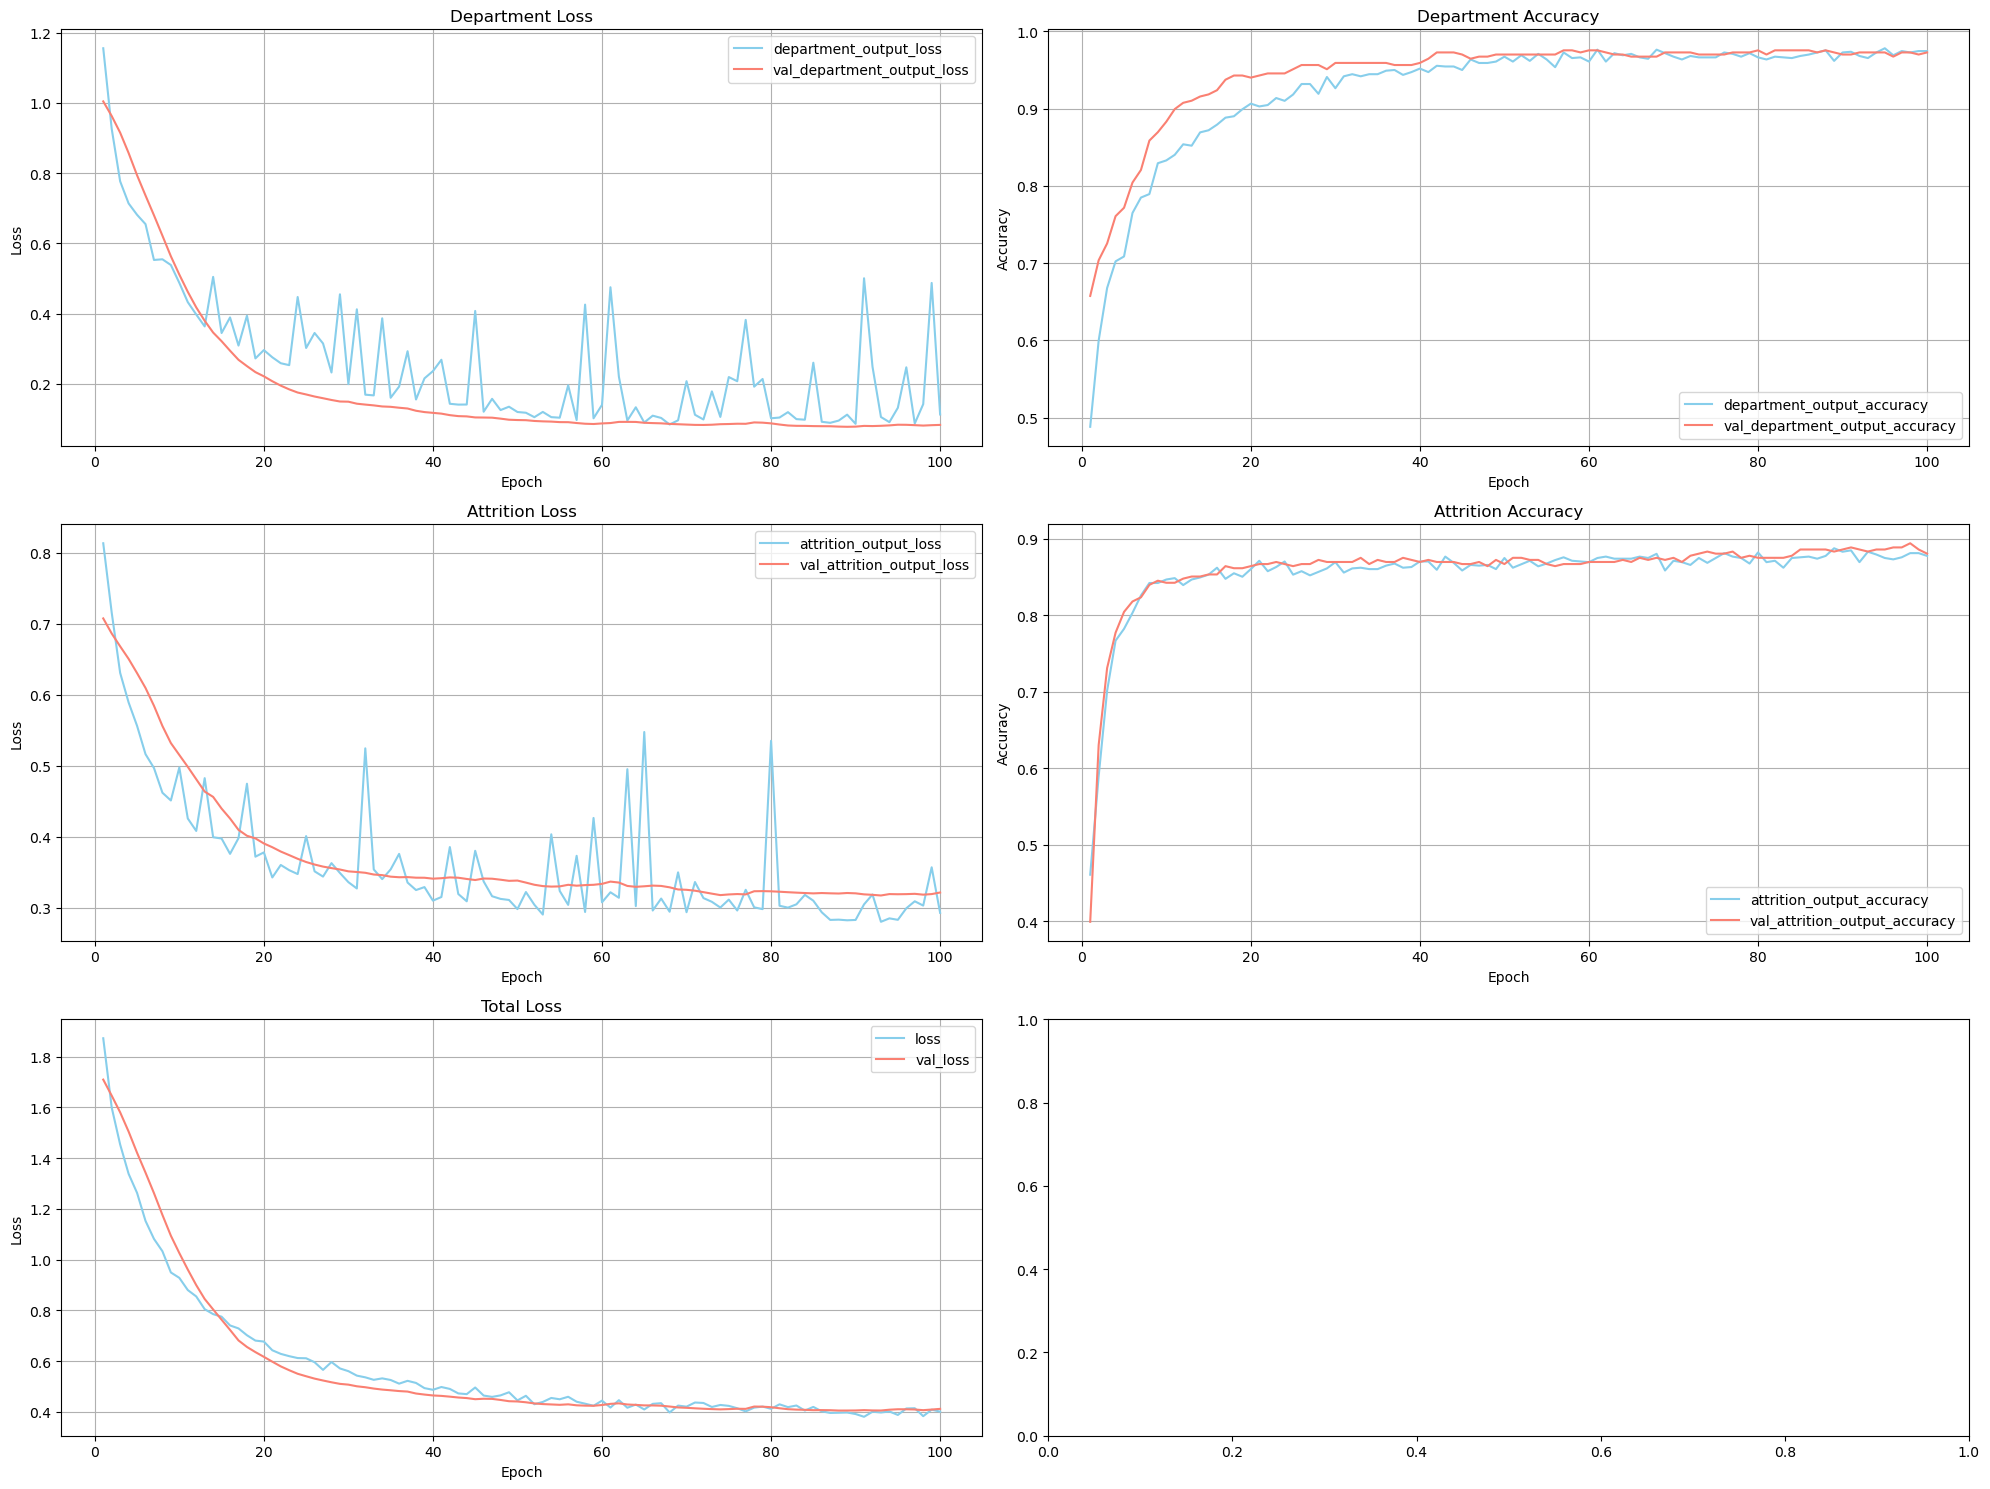

In [36]:
def plot_metric(history_df, metric, title, xlabel, ylabel, ax, style=['skyblue', 'salmon']):
    history_df.plot(
        y=[f'{metric}', f'val_{metric}'],
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        legend=True,
        grid=True,
        style=style,
        ax=ax
    )

fig, ax = plt.subplots(3, 2, figsize=(20, 15))


plot_metric(history_df, 'department_output_loss', 'Department Loss', 'Epoch', 'Loss', ax[0, 0])
plot_metric(history_df, 'department_output_accuracy', 'Department Accuracy', 'Epoch', 'Accuracy', ax[0, 1])
plot_metric(history_df, 'attrition_output_loss', 'Attrition Loss', 'Epoch', 'Loss', ax[1, 0])
plot_metric(history_df, 'attrition_output_accuracy', 'Attrition Accuracy', 'Epoch', 'Accuracy', ax[1, 1])
plot_metric(history_df, 'loss', 'Total Loss', 'Epoch', 'Loss', ax[2, 0])

plt.tight_layout()
plt.show()


#### Predict `y` and view classification report and confusion matrix

In [37]:
# Predict the `y` values using the testing data
y_predict = model.predict(X_test_scaled)

# Obtain the predicted attrition and department values
# Out of the 2 probabilities, we will select the index with the highest probability
attrition_predict = np.argmax(y_predict['attrition_output'], axis=1) # Ex. [9.9980766e-01, 1.9234979e-04] -> 0 -> 'No'

# Out of the 3 probabilities, we will select the index with the highest probability
department_predict = np.argmax(y_predict['department_output'], axis=1) # Ex. [6.2057213e-04, 9.9770653e-01, 1.6728503e-03] -> 1 => 'Research & Development'

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [38]:
# Create prediction dataframe
prediction_df = pd.DataFrame(
    data={
        'attrition_prediction': attrition_predict,
        'department_prediction': department_predict,
        'attrition_actual': np.argmax(attrition_encoded_test, axis=1),
        'department_actual': np.argmax(department_encoded_test, axis=1),
    },
    index=y_test.index,

)

prediction_df.head()

,attrition_prediction,department_prediction,attrition_actual,department_actual
285,0,1,0,1
775,0,2,0,2
358,0,2,0,2
1164,0,1,0,1
506,0,1,0,1


In [39]:
def style_conf_matrix(df):
    return (df.style.set_properties(**{'text-align': 'center'}).background_gradient(cmap='Oranges'))

In [40]:
# Create a classification report for the attrition predictions
attrition_report = classification_report(
    prediction_df['attrition_actual'],
    prediction_df['attrition_prediction'],
    target_names=[category.replace('Attrition_', ' ') + f' ({i})' for i, category in enumerate(attrition_encoder.get_feature_names_out(['Attrition']))],
)

print(attrition_report)

              precision    recall  f1-score   support

      No (0)       0.91      0.95      0.93       313
     Yes (1)       0.63      0.47      0.54        55

    accuracy                           0.88       368
   macro avg       0.77      0.71      0.74       368
weighted avg       0.87      0.88      0.87       368



In [41]:
attrition_conf_df = pd.DataFrame(
    confusion_matrix(
        prediction_df['attrition_actual'],
        prediction_df['attrition_prediction']
    ),
    index=[category.replace('Attrition_', 'Actual ') + f' ({i})' for i, category in enumerate(attrition_encoder.get_feature_names_out(['Attrition']))],
    columns=[category.replace('Attrition_', 'Predicted ') + f' ({i})' for i, category in enumerate(attrition_encoder.get_feature_names_out(['Attrition']))],
)

style_conf_matrix(attrition_conf_df)

,Predicted No (0),Predicted Yes (1)
Actual No (0),298,15
Actual Yes (1),29,26


In [42]:
# Create a classification report for the department predictions
department_report = classification_report(
    prediction_df['department_actual'],
    prediction_df['department_prediction'],
    target_names=[category.replace('Department_', '') + f' ({i})' for i, category in enumerate(department_encoder.get_feature_names_out(['Department']))],
)

print(department_report)

                            precision    recall  f1-score   support

       Human Resources (0)       0.80      0.80      0.80        10
Research & Development (1)       0.98      0.98      0.98       243
                 Sales (2)       0.97      0.97      0.97       115

                  accuracy                           0.97       368
                 macro avg       0.92      0.92      0.92       368
              weighted avg       0.97      0.97      0.97       368



In [43]:
department_conf_df = pd.DataFrame(
    confusion_matrix(
        prediction_df['department_actual'],
        prediction_df['department_prediction']
    ),
    index=[category.replace('Department_', 'Actual ') + f' ({i})' for i, category in enumerate(department_encoder.get_feature_names_out(['Department']))],
    columns=[category.replace('Department_', 'Predicted ') + f' ({i})' for i, category in enumerate(department_encoder.get_feature_names_out(['Department']))],
)

style_conf_matrix(department_conf_df)

,Predicted Human Resources (0),Predicted Research & Development (1),Predicted Sales (2)
Actual Human Resources (0),8,2,0
Actual Research & Development (1),1,239,3
Actual Sales (2),1,3,111


## Part 3: Summary
___

In the provided space below, briefly answer the following questions.

1. Is accuracy the best metric to use on this data? Why or why not?

2. What activation functions did you choose for your output layers, and why?

3. Can you name a few ways that this model might be improved?

YOUR ANSWERS HERE

1. Accuracy isn't the best because the data is imbalanced. For example, most people in this dataset didn't leave the company (`Attrition = "No"`), so a model that just predicts "No" will have high accuracy but won't really tell us much about predicting employee attrition (Yes). We should probably look at metrics like Precision, Recall, or F1-Score instead. This is evident because when I checked the (`Attrition = "Yes"`) the `precision` **(0.64)**, `recall` **(0.38)** and `f1-score` **(0.48)** are on the lower side. A low recall for `Attrition = "Yes"` means that the model is not very effective at identifying employees who are at risk of leaving. A precision of 0.64 means that 64% of the employees predicted to leave actually left. The F1-score of 0.48 indicates a balance between precision and recall, but both are low.

2. For Attrition, I used Sigmoid because it's good for predicting yes/no binary answers. For Department, I used Softmax since it works well when there are multiple classes to choose from (like predicting which department someone works in).

3. We can improve the model by addressing the class imbalance, like by oversampling the "Yes" for Attrition. We can also try tuning the model's settings to see if it performs better, and maybe adding more features or cleaning the data further. Maybe hyper parameter tuning. I did try feature engineering and inspection and noticed improvement to the original model. Furthermore, after some research and learning, I implemented Batch Normalization, Activation, and Dropout, on each layer to improve the model performance. This also significantly improved the model. However, the main thing about the model not being balanced does not change. 